# MACHINE LEARNING - INTERPRETABILITY AND THRESHOLD ADJUSTMENT

In this notebook we use the fitted model (optimized and trained) to focus not on the predictions labels, but on the prediction probabilities.

The idea is to see how the four main metrics (precisipon, accuracy, recall and F1 score) vary when we vary the detection threshold and apply it to a validation set.

## Modules and configuration

### Modules

In [39]:
import warnings

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import precision_score, accuracy_score, recall_score, f1_score

#from sklearn.experimental import enable_hist_gradient_boosting
# Not sure why this 'experimental' import is needed, as the sklearn version is 0.24.x > 0.21.x
from sklearn.ensemble import HistGradientBoostingClassifier

from joblib import dump, load

import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white", {'figure.figsize':(15,10)})

### Configuration

In [2]:
# CONFIGURATION:
RANDOM_STATE = 11 # For reproducibility

# FILES AND FOLDERS
SYNTH_DATASET = "../data/DATASETS_ML/DS4_Dataset.csv" # The already preprocessed one.
OUT_MODELS_FOLDER = "../data/MODELS_ML/"

# FEATURES TO KEEP - To remove the Lomb-Scargle (Periodic) 'cesium' features
TARGET_DS4 = ['Pulsating']
KEEP_CS_FEATURES = ['all_times_nhist_numpeaks',
                   'all_times_nhist_peak1_bin', 'all_times_nhist_peak2_bin', 'all_times_nhist_peak3_bin', 'all_times_nhist_peak4_bin',
                   'all_times_nhist_peak_1_to_2', 'all_times_nhist_peak_1_to_3', 'all_times_nhist_peak_1_to_4',
                   'all_times_nhist_peak_2_to_3', 'all_times_nhist_peak_2_to_4',
                   'all_times_nhist_peak_3_to_4',
                   'all_times_nhist_peak_val',
                   'avg_double_to_single_step', 'avg_err', 'avgt',
                   'cad_probs_1', 'cad_probs_10', 'cad_probs_20', 'cad_probs_30', 'cad_probs_40', 'cad_probs_50',
                   'cad_probs_100', 'cad_probs_500', 'cad_probs_1000', 'cad_probs_5000',
                   'cad_probs_10000', 'cad_probs_50000', 'cad_probs_100000', 'cad_probs_500000',
                   'cad_probs_1000000', 'cad_probs_5000000', 'cad_probs_10000000',
                   'cads_avg', 'cads_med', 'cads_std', 'mean',
                   'med_double_to_single_step', 'med_err',
                   'n_epochs', 'std_double_to_single_step', 'std_err',
                   'total_time', 'amplitude',
                   'flux_percentile_ratio_mid20', 'flux_percentile_ratio_mid35', 'flux_percentile_ratio_mid50',
                   'flux_percentile_ratio_mid65', 'flux_percentile_ratio_mid80',
                   'max_slope', 'maximum', 'median', 'median_absolute_deviation', 'minimum',
                   'percent_amplitude', 'percent_beyond_1_std', 'percent_close_to_median', 'percent_difference_flux_percentile',
                   'period_fast', 'qso_log_chi2_qsonu', 'qso_log_chi2nuNULL_chi2nu', 'skew', 'std',
                   'stetson_j', 'stetson_k', 'weighted_average', 'fold2P_slope_10percentile', 'fold2P_slope_90percentile']

# TRAIN/TEST SPLITS:
VALIDATION_SIZE = 0.25 # Fraction of DS4 reserved for model validation.


### Functions

## Load the train/test and validation dataset

In [3]:
ds4 = pd.read_csv(SYNTH_DATASET, sep=',', decimal='.')
ds4.head()

,all_times_nhist_numpeaks,all_times_nhist_peak1_bin,all_times_nhist_peak2_bin,all_times_nhist_peak3_bin,all_times_nhist_peak4_bin,all_times_nhist_peak_1_to_2,all_times_nhist_peak_1_to_3,all_times_nhist_peak_1_to_4,all_times_nhist_peak_2_to_3,all_times_nhist_peak_2_to_4,...,qso_log_chi2_qsonu,qso_log_chi2nuNULL_chi2nu,skew,std,stetson_j,stetson_k,weighted_average,fold2P_slope_10percentile,fold2P_slope_90percentile,Pulsating
0,8.0,22.0,32.0,34.0,47.0,1.037736,1.122449,1.527778,1.081633,1.472222,...,11.309243,-0.256635,-0.781648,3.165073,24.980336,0.958442,640.080094,-804.937332,734.364181,1
1,4.0,25.0,23.0,49.0,NaN,1.500000,2.000000,NaN,1.333333,NaN,...,10.193226,-0.719675,-0.066318,2.172986,18.856633,1.041665,1393.651760,-0.000084,0.000069,1
2,7.0,9.0,16.0,26.0,43.0,1.500000,1.500000,1.615385,1.000000,1.076923,...,9.388395,0.509991,0.234427,2.803447,22.406281,0.974131,1798.934279,-0.000131,0.000092,0
3,9.0,10.0,46.0,49.0,0.0,1.000000,1.000000,2.000000,1.000000,2.000000,...,12.881028,-0.441638,-0.583404,3.021310,27.726903,0.968993,918.862056,-0.000110,0.000187,0
4,7.0,23.0,26.0,19.0,3.0,1.000000,1.500000,3.000000,1.500000,3.000000,...,9.928810,-0.441719,0.653280,2.835690,24.866941,1.020485,-1374.121335,-0.000017,0.000029,1


## Train/test set and validation set split

We do a train/test set and validation set split, in order to extract a vaidation set where to test the model. It is assumed, as we make use of the variable `RANDOM_STATE` with a fixed value of 11.

**NOTE:** it is important to stratify the split with the target variable (`Pulsating` column).

We first separate the features from the target variable:

In [4]:
X = ds4.drop(columns=TARGET_DS4).copy()
y = ds4[TARGET_DS4].copy()

In [5]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=VALIDATION_SIZE,
                                                    stratify=y, random_state=RANDOM_STATE)

In [6]:
X_train.shape

(750, 67)

In [7]:
y_train.shape

(750, 1)

In [8]:
y_train[:10]

,Pulsating
303,0
425,1
6,1
457,1
619,0
34,1
935,0
52,1
674,1
33,1


In [9]:
np.ravel(y_train)[:10]

array([0, 1, 1, 1, 0, 1, 0, 1, 1, 1], dtype=int64)

In [10]:
X_val.shape

(250, 67)

In [11]:
y_val.shape

(250, 1)

## Load the fitted model

In [12]:
clf = load(OUT_MODELS_FOLDER + "Best_Model_After_RandSearchCV.joblib")

In [13]:
clf.best_estimator_

HistGradientBoostingClassifier(learning_rate=0.08887773751235287, max_iter=53,
                               max_leaf_nodes=None, min_samples_leaf=58,
                               random_state=11)

In [14]:
clf.decision_function(X_val[:1])

array([1.46739794])

In [15]:
clf.best_estimator_

HistGradientBoostingClassifier(learning_rate=0.08887773751235287, max_iter=53,
                               max_leaf_nodes=None, min_samples_leaf=58,
                               random_state=11)

In [33]:
loaded_clf.best_estimator_.predict(X_val)

array([1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 0], dtype=int64)

**NOTE:** Unfortunately, this model does not seem to give access to the component decision trees nor a feature importance functionality, which hinders interpretability.

## Adjusting the detection threshold

In [16]:
clf.best_estimator_.predict_proba(X)

array([[0.35696228, 0.64303772],
       [0.17425375, 0.82574625],
       [0.55507902, 0.44492098],
       ...,
       [0.26058244, 0.73941756],
       [0.500487  , 0.499513  ],
       [0.70845148, 0.29154852]])

In [17]:
clf.best_estimator_.predict(X)

array([1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1,

### Variation of metrics with the detection threshold

We now try to see how the four metrics change with the customized detection threshold.

Additionally, we also calculate how many stars will fall above the selected detection threshold (i.e. to be included in a future survey) and, from those stars, how many are really pulsating ones, in order to predict a _success ratio_ of the survey.

In [18]:
# Create the thresholds values to be tested.
thr = np.linspace(start=0.0, stop=1.0, num=101, endpoint=True)
thr

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [136]:
# Create a dataframe with all the metrics for all the possible thresholds
res_df = pd.DataFrame(columns=['Detection threshold', 'precision', 'accuracy', 'recall', 'F1_score',
                               'Nr. stars to survey', 'Expected pulsators', 'Survey ratio', 'Detection ratio'])
res_df.head()
# Populate the results DataFrame:
#for threshold in thr[:2]: # TEST
#for threshold in thr[48:50]: # TEST
for threshold in thr:
    # Calculate predictions for this threshold:
    y_proba = clf.best_estimator_.predict_proba(X_val)
    y_pred = [1 if elem[1] > threshold else 0 for elem in y_proba]
    # Calculate performance:
    precision = precision_score(y_val, y_pred)
    accuracy = accuracy_score(y_val, y_pred)
    recall = recall_score(y_val, y_pred)
    f1 = f1_score(y_val, y_pred)
    # We also calculate the fraction of stars labelled as pulsating (i.e. that will be surveyed),
    # and the fraction of stars (from those "surveyed") that are really pulsating.
    surveyed_stars = y_pred.count(1)
    survey_ratio = surveyed_stars / len(y_val)
    pulsators_detected = sum([1 if (a == 1 and b == 1) else 0
                              for a, b in zip(y_pred, y_val.values)])
    detection_ratio = pulsators_detected / sum(np.ravel(y_val.values == 1))
    # Update the table:
    new_data = pd.DataFrame(data={
        'Detection threshold': threshold,
        'precision': precision,
        'accuracy': accuracy,
        'recall': recall,
        'F1_score': f1,
        'Nr. stars to survey': surveyed_stars,
        'Expected pulsators': pulsators_detected,
        'Survey ratio': survey_ratio, # The ratio of stars that must be surveyed
        'Detection ratio': detection_ratio # The ratio of the pulsating stars detected. 
    }, index=[0])
    res_df = pd.concat([res_df, new_data], ignore_index=True)

C:\Users\ciroe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ciroe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ciroe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\ciroe\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision 

In [144]:
res_df

,Detection threshold,precision,accuracy,recall,F1_score,Nr. stars to survey,Expected pulsators,Survey ratio,Detection ratio
0,0.00,0.704,0.704,1.0,0.826291,250,176,1.0,1.0
1,0.01,0.704,0.704,1.0,0.826291,250,176,1.0,1.0
2,0.02,0.704,0.704,1.0,0.826291,250,176,1.0,1.0
3,0.03,0.704,0.704,1.0,0.826291,250,176,1.0,1.0
4,0.04,0.704,0.704,1.0,0.826291,250,176,1.0,1.0
...,...,...,...,...,...,...,...,...,...
96,0.96,0.000,0.296,0.0,0.000000,0,0,0.0,0.0
97,0.97,0.000,0.296,0.0,0.000000,0,0,0.0,0.0
98,0.98,0.000,0.296,0.0,0.000000,0,0,0.0,0.0
99,0.99,0.000,0.296,0.0,0.000000,0,0,0.0,0.0


In [138]:
# SAVE THE RESULT:
res_df.to_csv("./Detection_threshold_effect.csv", sep=',', decimal='.', index=False)

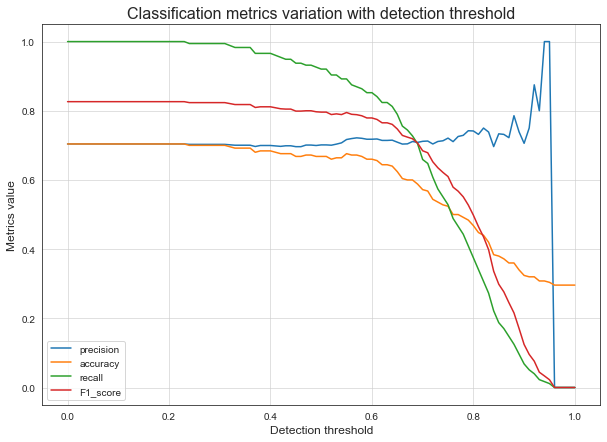

In [142]:
# We now plot the variation of the metrics:
plt.figure(figsize=(10,7))
plt.title("Classification metrics variation with detection threshold", fontsize=16)
plt.grid(axis='both', alpha=0.75)
plt.xlabel("Detection threshold", fontsize=12)
plt.ylabel("Metrics value", fontsize=12)
sns.lineplot(data=res_df, x='Detection threshold', y='precision', label='precision')
sns.lineplot(data=res_df, x='Detection threshold', y='accuracy', label='accuracy')
sns.lineplot(data=res_df, x='Detection threshold', y='recall', label='recall')
sns.lineplot(data=res_df, x='Detection threshold', y='F1_score', label='F1_score')
plt.legend();
plt.savefig("./img/MachineLearnig_35_01_Detection_threshold_adjustment.png", format='png')
plt.plot();

As can be seen, with detection thresholds between 0.4 and 0.8 threshold there is a high variability on the metrics, so that we have many choices about that value in order to focus on the metric we are more interested in.

It is interesting to note that precision remains almost constant at about a value of $\approx0.7$, which is very similar to the prior probability of pulsating stars.

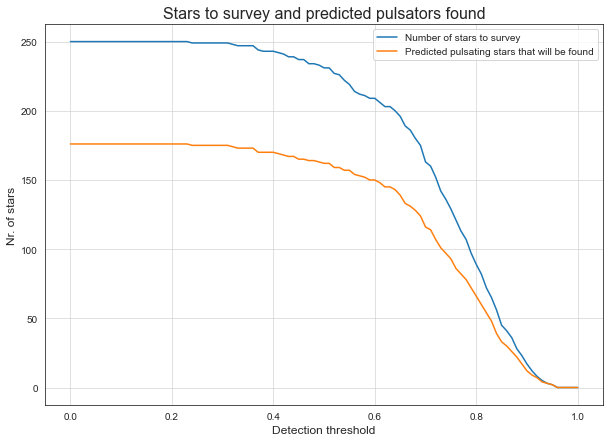

In [149]:
# We now plot the survey size and the expected number of pulsators found:
plt.figure(figsize=(10,7))
plt.title("Stars to survey and predicted pulsators found", fontsize=16)
plt.grid(axis='both', alpha=0.75)
plt.xlabel("Detection threshold", fontsize=12)
plt.ylabel("Nr. of stars", fontsize=12)
sns.lineplot(data=res_df, x=res_df['Detection threshold'], y=res_df['Nr. stars to survey'].astype(float),
             label='Number of stars to survey')
sns.lineplot(data=res_df, x=res_df['Detection threshold'], y=res_df['Expected pulsators'].astype(float),
             label='Predicted pulsating stars that will be found')
plt.legend();
plt.savefig("./img/MachineLearnig_35_02_Survey_size_and_expected_success.png", format='png')
plt.plot();

In the above graphic, we could use two different values as an entry:

- The number of stars we are able to survey, which could be limited by observation time or budgetary reasons.
- The number of pulsating stars we want to find, in case there is no budget or time constraints.

In any case, the graph will give both the detection threshold to use and the value of the other parameter, in essence answering these two questions:

- If we survey X stars, ¿how many pulsators do we expect to discover?
- ¿How many stars do we need to survey if we want to find Y pullsators?
